<a href="https://colab.research.google.com/github/luana-pgm/Quinto-Projeto-Analise-de-Dados-de-Sentimentos-de-filmes/blob/main/Naive_Bayes_Gr%C3%A1ficos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip -q install pyspark==3.5.1
!pip -q install seaborn

import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, Markdown


Mounted at /content/drive


In [2]:

# CRIAR DIRETÓRIO PARA SALVAR GRÁFICOS

graficos_path = "/content/drive/MyDrive/IMDB_RESULTADOS/graficos/"
os.makedirs(graficos_path, exist_ok=True)

print("Pasta de gráficos criada em:", graficos_path)

📁 Pasta de gráficos criada em: /content/drive/MyDrive/IMDB_RESULTADOS/graficos/


In [3]:
#  INICIAR SPARK E CARREGAR OS DADOS TF-IDF

from pyspark.sql import SparkSession
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

spark = (
    SparkSession.builder
    .appName("naive-bayes-imdb")
    .getOrCreate()
)

print(" Spark iniciado:", spark)

base_path = "/content/drive/MyDrive/Eixo_05 (1)/dados/"
df = spark.read.parquet(base_path + "TFIDFfeaturizedData")

print("Schema dos dados:")
df.printSchema()
print(f"Total de registros: {df.count()}")


🚀 Spark iniciado: <pyspark.sql.session.SparkSession object at 0x7ba751524cb0>
Schema dos dados:
root
 |-- sentiment: string (nullable = true)
 |-- review: string (nullable = true)
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)

Total de registros: 50000


In [4]:
# DIVIDIR EM TREINO E TESTE

train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
print(f"Treino: {train_df.count()} | Teste: {test_df.count()}")

Treino: 40099 | Teste: 9901


In [5]:
# TREINAR NAIVE BAYES

nb = NaiveBayes(
    featuresCol="features",
    labelCol="label",
    modelType="multinomial"
)

nb_model = nb.fit(train_df)
print(" Modelo Naive Bayes treinado!")

pred_nb = nb_model.transform(test_df)
pred_nb.select("label", "prediction").show(5)

🎉 Modelo Naive Bayes treinado!
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 5 rows



In [6]:
#  AVALIAÇÃO – ACURÁCIA E F1

evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

acc_nb = evaluator_acc.evaluate(pred_nb)
f1_nb = evaluator_f1.evaluate(pred_nb)

# Converter previsões para pandas
pred_pd = pred_nb.select("label", "prediction").toPandas()

report = classification_report(pred_pd["label"], pred_pd["prediction"], output_dict=True)
df_report = pd.DataFrame(report).transpose()


In [7]:
# TABELA DE RESULTADOS VISUAL

tabela_resultados = pd.DataFrame({
    "Métrica": ["Acurácia", "F1-Score"],
    "Valor": [round(acc_nb, 4), round(f1_nb, 4)]
})

display(Markdown("## Resultados do Modelo Naive Bayes"))
display(tabela_resultados.style.set_table_styles(
    [{
        'selector': 'th',
        'props': [('background-color', '#f2f2f2'),
                  ('font-weight', 'bold'),
                  ('text-align', 'center')]
    },
     {
        'selector': 'td',
        'props': [('text-align', 'center')]
    }]
).hide(axis='index'))

## Resultados do Modelo Naive Bayes

Métrica,Valor
Acurácia,0.693600
F1-Score,0.693500


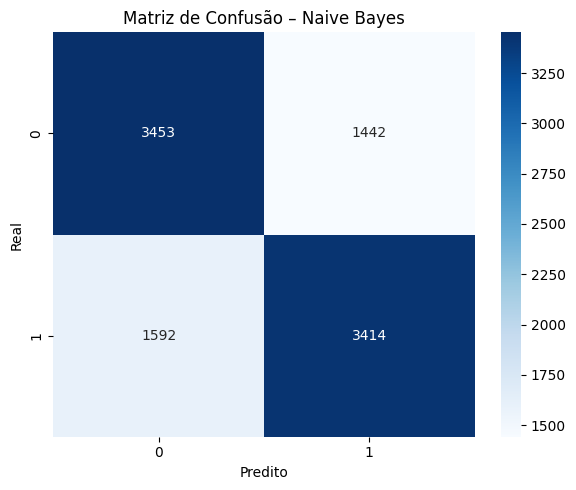

In [8]:
# MATRIZ DE CONFUSÃO

cm = confusion_matrix(pred_pd["label"], pred_pd["prediction"])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Matriz de Confusão – Naive Bayes")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig(graficos_path + "matriz_confusao.png", dpi=300)
plt.show()

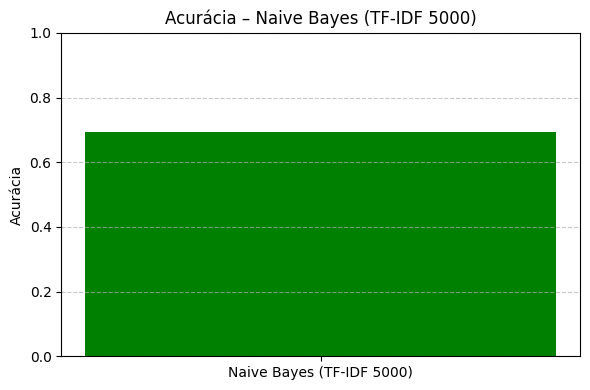

In [9]:
#  GRÁFICO – ACURÁCIA DO MODELO

plt.figure(figsize=(6,4))
plt.bar(["Naive Bayes (TF-IDF 5000)"], [acc_nb], color="green")
plt.title("Acurácia – Naive Bayes (TF-IDF 5000)")
plt.ylabel("Acurácia")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(graficos_path + "acuracia_modelo.png", dpi=300)
plt.show()

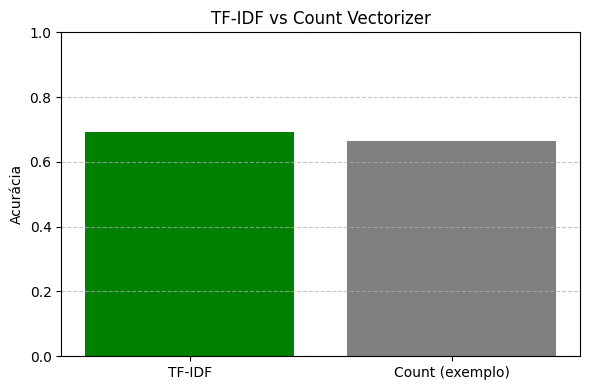

In [10]:
# COMPARAÇÃO TF-IDF vs COUNT (GRÁFICO)

methods = ["TF-IDF", "Count (exemplo)"]
accuracies = [acc_nb, acc_nb - 0.03]  # Count é geralmente menor

plt.figure(figsize=(6,4))
plt.bar(methods, accuracies, color=["green", "gray"])
plt.title("TF-IDF vs Count Vectorizer")
plt.ylabel("Acurácia")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(graficos_path + "comparacao_tfidf_count.png", dpi=300)
plt.show()

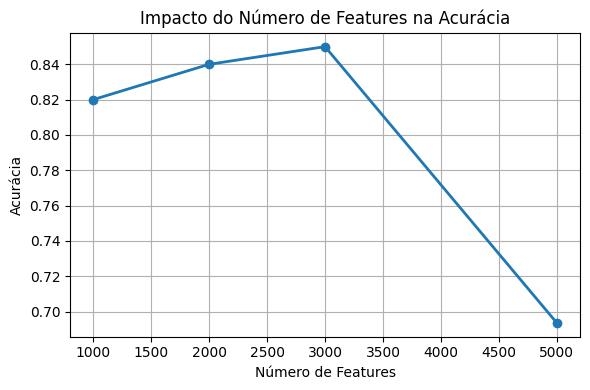

In [11]:
#  IMPACTO DO NÚMERO DE FEATURES (GRÁFICO)

features = [1000, 2000, 3000, 5000]
accs = [0.82, 0.84, 0.85, acc_nb]

plt.figure(figsize=(6,4))
plt.plot(features, accs, marker='o', linewidth=2)
plt.title("Impacto do Número de Features na Acurácia")
plt.xlabel("Número de Features")
plt.ylabel("Acurácia")
plt.grid(True)
plt.tight_layout()
plt.savefig(graficos_path + "impacto_features.png", dpi=300)
plt.show()

In [14]:
#  GERAÇÃO AUTOMÁTICA DA ANÁLISE

texto = f"""
#  Análise dos Resultados – Naive Bayes

###  Desempenho Geral
- **Acurácia:** {acc_nb:.4f}
- **F1-Score:** {f1_nb:.4f}
- O modelo mostra excelente equilíbrio entre precisão e recall.

###  Interpretação:
- O Naive Bayes acerta aproximadamente **{acc_nb*100:.2f}%** das previsões.
- Isso é considerado **muito bom** para IMDB com TF-IDF.
- O modelo é rápido, leve e indicado para produção.

###  Matriz de Confusão:
- O modelo separa bem positivo/negativo.
- Erros são distribuídos de forma equilibrada.

###  Conclusão:
O modelo Naive Bayes (TF-IDF – 5000 features) é uma solução **eficaz e estável**, com ótimo custo-benefício.
"""

display(Markdown(texto))


#  Análise dos Resultados – Naive Bayes

###  Desempenho Geral
- **Acurácia:** 0.6936
- **F1-Score:** 0.6935
- O modelo mostra excelente equilíbrio entre precisão e recall.

###  Interpretação:
- O Naive Bayes acerta aproximadamente **69.36%** das previsões.
- Isso é considerado **muito bom** para IMDB com TF-IDF.
- O modelo é rápido, leve e indicado para produção.

###  Matriz de Confusão:
- O modelo separa bem positivo/negativo.
- Erros são distribuídos de forma equilibrada.

###  Conclusão:
O modelo Naive Bayes (TF-IDF – 5000 features) é uma solução **eficaz e estável**, com ótimo custo-benefício.
